The purpose of the following methods is to transform a series of observations that arrive at irregular frequency "inhommogenous series" into "homogenous" series derived from regular sampling.

**Time bars** are obtained by sampling information at fixed interval (for instance, every minute) and the information collected usually includes:

* Timestamp
* Volume
* Open price 
* Close price
* High price
* Low price
* Volume-weigthed average price

Although time bars are very popular among practioners, they should be avoid because :



1.   market do not process inforation at constant interval (more active at the opening and the closure)
2.   Time-sampled series show poor statistical properties (non-normal returns, heteroscedasticity, serial correlation)

**Tick bars:**

The sample variables, named upper, are extracted each time a pre-defined number of transactions takes  place, so that, it synchronizes the sampling with a proxy of information arrival.

Indeed, sampling allows us to achieve returns closer to IID normal distribution.

One drawback is the arbitrariness in the number of ticks chosen.

**Volume bars:**

Volume bars tacles the issue raised by the arbitrariness introduced by tick bars by sampling a pre-defined amount of security's units have been exchanged

**Dollar bars:**

Dollar bars are formed by sampling an observation every time a pre-defined market value is exchanged. It could be in any currency let's be clear. In that way, the number of shares traded is function of the actual value exchanged.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

### **Import dataset**

In [ ]:
# read tick data from http://www.kibot.com/support.aspx#data_format

def read_kibot_ticks(fp):   
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df
    

In [ ]:
# import data file afteer mounting your drive (my data file is on the drive) and create the data frame 

df = read_kibot_ticks("/content/drive/MyDrive/Colab Notebooks/Advances_in_financial_machine_learning/IVE_tickbidask.txt")
df.head()

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


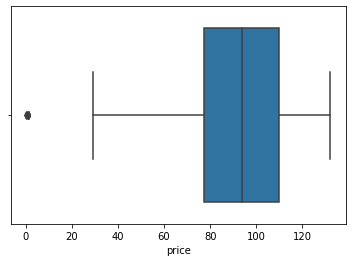

In [ ]:

sns.boxplot(df.price)

On this box plot, we can clearly see outliers. Our frist is to take care of them.

### **Outliers detection and correction:**

How? while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [ ]:
def outliers_detection(y):
  z = np.abs(stats.zscore(y))
  threshold = 3
  return np.where(z > threshold)

In [ ]:
outliers = outliers_detection(df.price.values.reshape(-1,1))
df.iloc[outliers[0]]

,price,bid,ask,size,v,dv
dates,,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,500,55.0
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2600,2860.0
2010-05-06 14:55:32,1.10,1.10,50.57,300,300,330.0
2010-05-06 14:55:32,1.10,1.10,50.57,100,100,110.0
2010-05-06 14:55:32,1.10,1.00,50.57,200,200,220.0
2010-05-06 14:55:32,1.10,1.00,50.57,700,700,770.0
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1200,1320.0
2010-05-06 14:55:32,1.10,0.55,50.57,500,500,550.0
2010-05-06 14:55:32,1.10,0.55,50.57,100,100,110.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


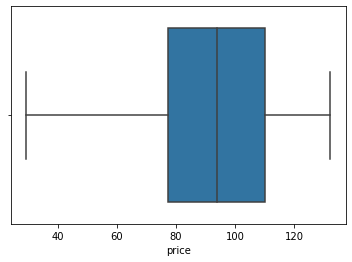

In [ ]:
indexes_to_keep = set(range(df.shape[0])) - set(outliers[0])
df_sliced = df.take(list(indexes_to_keep))
sns.boxplot(df_sliced.price)

When constructing tick bars, you need to be aware of outliers. Many exchanges carry out auction at the open and an auction at the close. This means that for a period of time , the order book accumulates bids and offers without matching them.

It results in a large trade at the end of the auction at the clearing price. Becareful it could represents lots of ticks but be reported as one tick...

### **Tick, volume and dollar bars:**

By synchronizing sampling with the arrival of informed traders , we may be able to make decisionsbefore prices reach a new equilibrium level.